Time Series Analysis - Decomposition of Electricity consumption into 3 components - Trend, Seasonality, Cyclicity and Irregular Noise

Trend - overall direction ie upwards, downwards or neutral
Seasonality - seasonal patterns - weekly, monthly, quarterly, half-yearly or yearly
Cyclicity - long term consumption/ business cycle which generally ranges from 3 - 7 years or more
Irregular Noise - Component which is not explained by any of the above

**It is easier to predict the individual patterns like Trend, Seasonality, Cyclicity and Noise through de-composition than predicting through the overall series.**

In [1]:
import warnings
import itertools
import os

import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('bmh')

In [2]:
os.listdir()

['DSP_May21_Weekend_Class_19_STATS.ipynb',
 'ML_TM_Class9_10_11_12_WebScraping.ipynb',
 'DSP_May21_Weekend_Class_11-EDA-loc-iloc-rename-drop-dtypeconv-duplicates-outliertreat.ipynb',
 'ML_TM_Class13_14_End to End LDA (with optional code for Tuning)-FINAL.ipynb',
 '.Rhistory',
 '.config',
 'Misc',
 'Music',
 'ML_TM_Class15_Running ANN using keras.ipynb',
 'medium size bikes & cycling accessories Cohort Analysis.ipynb',
 '.kaggle',
 'Assgnmnt_BasicStats_HypothesisTesting.ipynb',
 '.condarc',
 '.docker',
 'ML_TM_Class13_14_NLP based Feature Reduction.ipynb',
 'ML_TM_Class7_Bank Marketing Case Study (Response Modelling) - KNN, NB and SVM.ipynb',
 'DSP_May21_Weekend_Class_12-EDA-missingValues-grouping&binning.ipynb',
 'DSP_May21_Weekend_Class_2-datatypes-operators-conditionalstatements.ipynb',
 'ML_Capstone_Assignment_15 - Customer Review Analysis.ipynb',
 'ModelTrainer_LSTM.ipynb',
 '.DS_Store',
 'nltk_data',
 'DSP_May21_Weekend_Class_14_groups-bins-apply-applymap-aggre-data&time.ipynb',
 

In [3]:
os.chdir('/Users/BackUp/AnalytixLabs/MachineLearning_TextMining/Assignmnts/13. Capstone Case Study - Demand Estimation')
os.listdir()

['AirPassengers.csv',
 'Electricity Consumption copy.csv',
 '13. Final Capstone Project - Demand Estimation.pdf',
 '.DS_Store',
 'Electricity Consumption.csv',
 'Electricity Consumption copy..xlsx']

In [4]:
elec_cons = pd.read_csv('Electricity Consumption.csv')
elec_cons.tail()

,DATE,Electricty_Consumption_in_TW
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765
560,9/1/2019,109.7190


In [5]:
elec_cons.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [6]:
elec_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [7]:
# convert the DATE column to dates series

dates = pd.date_range(start = '1/1/1973', freq = 'MS', periods = len(elec_cons))
dates

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', length=561, freq='MS')

In [8]:
# makes the dates series as the index of the data

elec_cons.set_index(dates, inplace = True)
elec_cons.drop(columns = 'DATE', axis = 1, inplace = True)
elec_cons.head()

,Electricty_Consumption_in_TW
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107


In [9]:
elec_cons.tail()

,Electricty_Consumption_in_TW
2019-05-01,97.5860
2019-06-01,110.8580
2019-07-01,122.1014
2019-08-01,121.7765
2019-09-01,109.7190


In [10]:
import calendar
elec_cons['Month'] = dates.month
elec_cons['Month'] = elec_cons['Month'].apply(lambda x : calendar.month_abbr[x])
elec_cons['Year'] = dates.year
elec_cons = elec_cons[['Month', 'Year', 'Electricty_Consumption_in_TW']]
elec_cons.rename(columns = {'Electricty_Consumption_in_TW' : 'Elec_Cons_TW'}, inplace = True)
elec_cons.head()

,Month,Year,Elec_Cons_TW
1973-01-01,Jan,1973,35.9728
1973-02-01,Feb,1973,36.1334
1973-03-01,Mar,1973,35.0625
1973-04-01,Apr,1973,33.8416
1973-05-01,May,1973,33.5107


**Data Prepaparion**

   - Make sure that the data has a continious Time Period in the same format
   - Missing Value Treatment
   - Outlier Treatment
   - Making the data indexed with Time (Making it to be Time Series data)
   - Optional: train-test split

In [11]:
# function for EDA 
def eda(col):
    
    n = col.shape[0]
    nmiss = col.isna().sum()
    perc_miss = ( nmiss / n ) * 100
    
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    u_cutoff = q3 + (1.5 * iqr)
    l_cutoff = q1 - (1.5 * iqr)
    
    return pd.Series([n, nmiss, perc_miss, col.mean(), col.std(), col.var(), l_cutoff, col.min(), col.quantile(0.01), 
                      col.quantile(0.05),col.quantile(0.1), col.quantile(0.25), col.quantile(0.5), col.quantile(0.75),
                      col.quantile(0.95), u_cutoff, col.quantile(0.99), col.max()], 
                    index = ['Total', 'TotalMissing', 'PercMissing', 'Mean', 'Std', 'Var', 'Lower_CutOff-IQR', 'Min',
                             'P1', 'P5', 'P10','P25','P50','P75','P95','Upper_CutOff-IQR','P99','Max'])

In [12]:
# checking for outlier in the data

eda(elec_cons.Elec_Cons_TW)

Total               561.000000
TotalMissing          0.000000
PercMissing           0.000000
Mean                 76.681764
Std                  22.756474
Var                 517.857124
Lower_CutOff-IQR     -0.961650
Min                  33.510700
P1                   36.409540
P5                   40.720100
P10                  45.579500
P25                  55.919700
P50                  78.417000
P75                  93.840600
P95                 111.852000
Upper_CutOff-IQR    150.721950
P99                 120.926540
Max                 123.216300
dtype: float64

Data has continuous time period in same format. It does not have any missing values. It does not have any outliers and date has been indexed. 

In [13]:
plt.axhline?

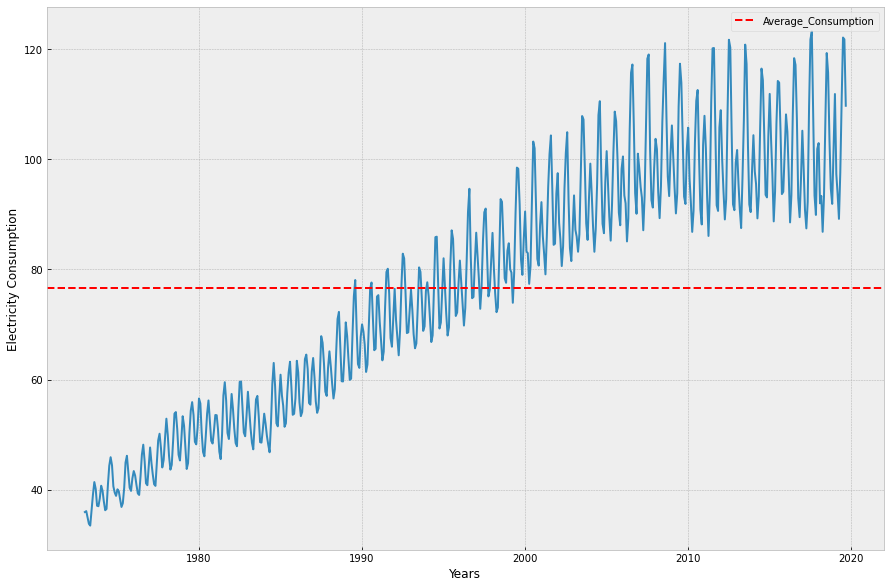

In [14]:
# plotting the electricity consumption

consumption = elec_cons.Elec_Cons_TW
plt.figure(figsize = (15, 10))
plt.plot(consumption)
plt.axhline(consumption.mean(), c = 'red', ls = '--', lw = 2.0, label = 'Average_Consumption')
plt.xlabel('Years')
plt.ylabel('Electricity Consumption')
plt.legend(loc = 'best')
plt.show()

In [15]:
# Making the data de-seasonalized by using moving averages

consumption.rolling(window = 4).mean()

1973-01-01           NaN
1973-02-01           NaN
1973-03-01           NaN
1973-04-01     35.252575
1973-05-01     34.637050
                 ...    
2019-05-01     94.485000
2019-06-01     97.867975
2019-07-01    104.933175
2019-08-01    113.080475
2019-09-01    116.113725
Freq: MS, Name: Elec_Cons_TW, Length: 561, dtype: float64

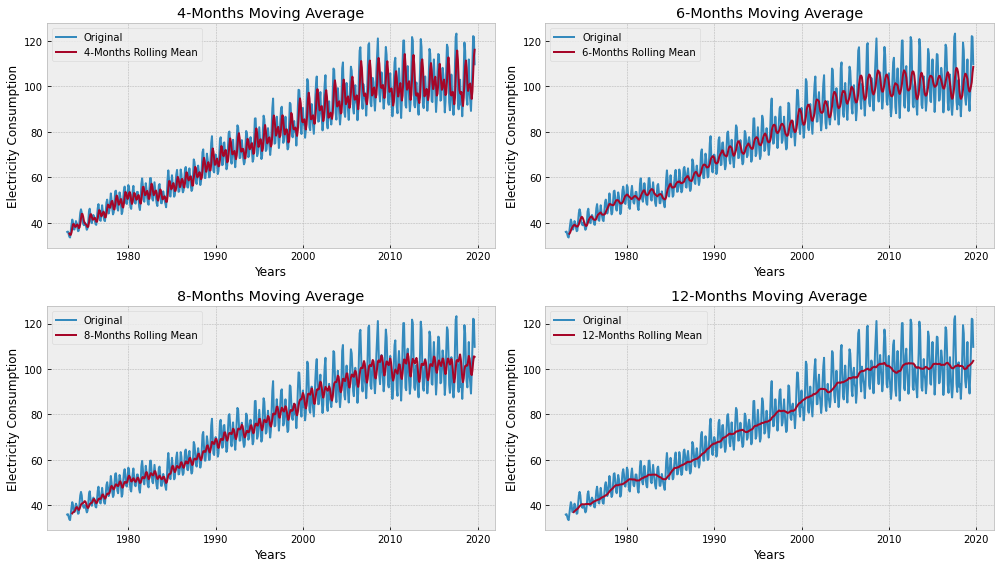

In [16]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(consumption.index, consumption, label='Original')
axes[0][0].plot(consumption.index, consumption.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Electricity Consumption")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(consumption.index, consumption, label='Original')
axes[0][1].plot(consumption.index, consumption.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Electricity Consumption")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(consumption.index, consumption, label='Original')
axes[1][0].plot(consumption.index, consumption.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Electricity Consumption")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(consumption.index, consumption, label='Original')
axes[1][1].plot(consumption.index, consumption.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Electricity Consumption")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

The rolling mean with 12 month window produces the most smooth line. It is to be expected since we are dealing with monthly consumption data here. 

### 1. Decomposition - Seasonality

The first thing to observe is what is the consumption pattern on monthly basis. We will plot a stacked annual consumption to observe seasonality in our data. 

In [17]:
elec_cons.head()

,Month,Year,Elec_Cons_TW
1973-01-01,Jan,1973,35.9728
1973-02-01,Feb,1973,36.1334
1973-03-01,Mar,1973,35.0625
1973-04-01,Apr,1973,33.8416
1973-05-01,May,1973,33.5107


In [18]:
monthly_consumption = elec_cons.pivot_table(values = 'Elec_Cons_TW', columns = 'Year', index = 'Month')
monthly_consumption = monthly_consumption.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_consumption.fillna(0)

Year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Month,,,,,,,,,,,,,,,,,,,,,
Jan,35.9728,40.7455,40.0956,43.4099,47.6892,52.9153,53.3617,56.5838,53.5867,57.4002,...,105.7413,107.8967,108.9151,101.6890,104.3752,111.8708,108.1515,105.1879,102.9398,111.8520
Feb,36.1334,39.8340,39.6944,42.5826,44.8505,49.9488,51.6279,55.6802,53.5461,54.6248,...,96.4428,101.9572,100.0117,95.5366,97.7907,103.4990,104.9900,98.0069,92.0095,97.3261
Mar,35.0625,37.9408,38.3040,40.9244,42.8557,46.1749,47.8264,50.4428,51.0708,51.1896,...,92.2986,93.2285,94.3484,91.0434,95.5280,97.4134,97.5969,90.8029,93.3526,93.8406
Apr,33.8416,36.3004,36.8939,39.3533,41.0177,43.6652,43.7935,46.8693,46.9172,48.4958,...,86.8242,86.0874,89.0821,87.5189,89.2783,88.7323,88.5477,87.4594,86.8386,89.1873
May,33.5107,36.5293,37.5668,39.0766,40.7201,44.5402,44.8591,46.0886,45.5795,47.9140,...,90.6389,93.7706,92.7937,96.5166,93.2729,94.1360,93.5168,92.2811,93.2361,97.5860
Jun,36.4823,40.8899,40.3832,42.4851,45.0610,48.9480,50.3292,49.7595,50.0235,54.5292,...,103.0377,110.3572,108.5421,107.0627,105.7336,106.5504,108.1813,109.6104,107.1009,110.8580
Jul,39.1412,44.3563,44.9671,46.3693,48.9685,53.8292,54.3579,53.8273,57.1384,59.5975,...,110.6045,120.1457,121.6974,120.8149,116.4651,114.2235,118.3568,121.7478,119.2874,122.1014
Aug,41.4137,45.9240,46.1853,48.1945,50.1898,54.1182,55.9197,56.2272,59.5376,59.6727,...,112.5792,120.2087,120.2822,117.2932,114.3700,113.9230,117.1375,123.2163,115.7108,121.7765
Sep,40.1639,44.4555,43.3001,45.1688,47.5982,50.9980,53.5776,52.5737,56.1935,54.9644,...,100.4701,106.1109,104.6692,102.4185,104.3899,104.9454,107.3046,108.4514,103.4070,109.7190


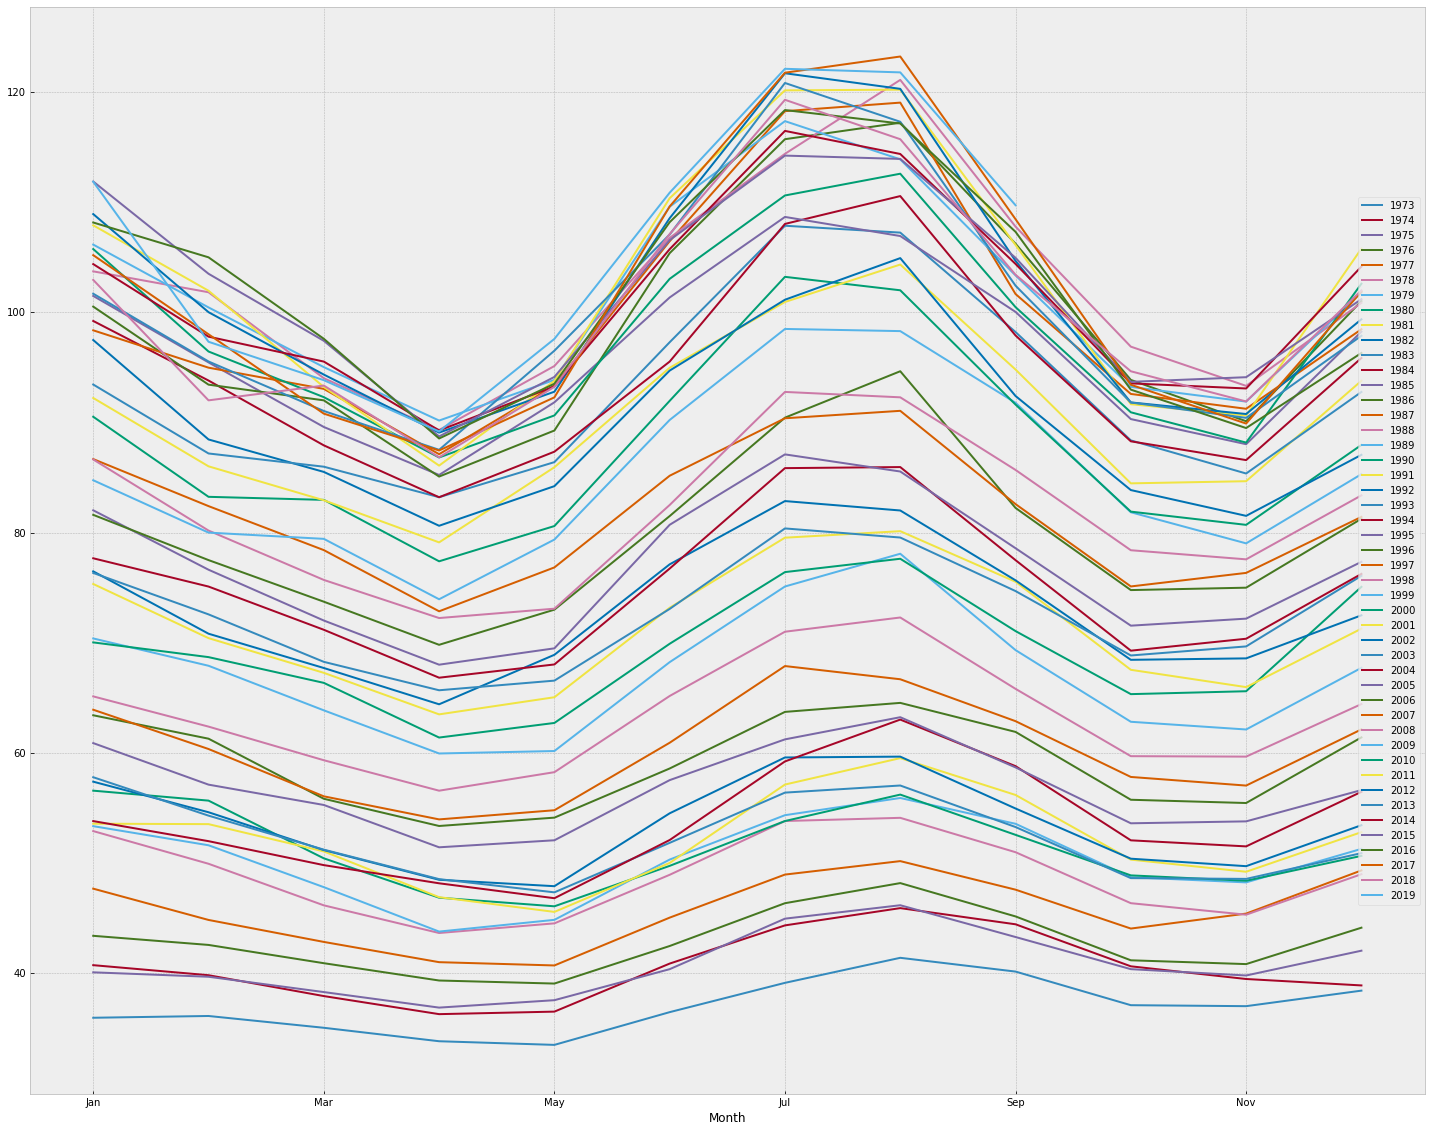

In [19]:
plt.rcParams["figure.figsize"] = (25,20)
monthly_consumption.plot()
plt.legend(loc = 'right')
plt.show()

From the plot, it is evident that there is dip in consumption between Mar to May and around Nov. This dip has been more pronounced in the later years as compared to the initial years. This may be explained by the pleasant weather during these months which does not require either AC or geysors. There is gradual increase in consumption from May onwards with peak at around month of Jul and there is also gradual increase in consumption from Nov onwards with peak at around Dec - Jan. The hot months of Jun - Jul require more ACs while cold months of Dec - Jan require more of geysors. 

### Now looking for Yearly Seasonality

In [20]:
yearly_consumption = elec_cons.pivot_table(values = 'Elec_Cons_TW', columns = 'Month', index = 'Year')
yearly_consumption = yearly_consumption[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_consumption.fillna(0)

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1973,35.9728,36.1334,35.0625,33.8416,33.5107,36.4823,39.1412,41.4137,40.1639,37.1133,37.0248,38.4341
1974,40.7455,39.8340,37.9408,36.3004,36.5293,40.8899,44.3563,45.9240,44.4555,40.6417,39.4901,38.9068
1975,40.0956,39.6944,38.3040,36.8939,37.5668,40.3832,44.9671,46.1853,43.3001,40.3836,39.8092,42.0597
1976,43.4099,42.5826,40.9244,39.3533,39.0766,42.4851,46.3693,48.1945,45.1688,41.1880,40.8431,44.1468
1977,47.6892,44.8505,42.8557,41.0177,40.7201,45.0610,48.9685,50.1898,47.5982,44.0684,45.4267,49.3447
1978,52.9153,49.9488,46.1749,43.6652,44.5402,48.9480,53.8292,54.1182,50.9980,46.3711,45.3267,49.0027
1979,53.3617,51.6279,47.8264,43.7935,44.8591,50.3292,54.3579,55.9197,53.5776,48.7261,48.2585,51.3008
1980,56.5838,55.6802,50.4428,46.8693,46.0886,49.7595,53.8273,56.2272,52.5737,48.8947,48.4081,50.6659
1981,53.5867,53.5461,51.0708,46.9172,45.5795,50.0235,57.1384,59.5376,56.1935,50.3249,49.2234,52.8176


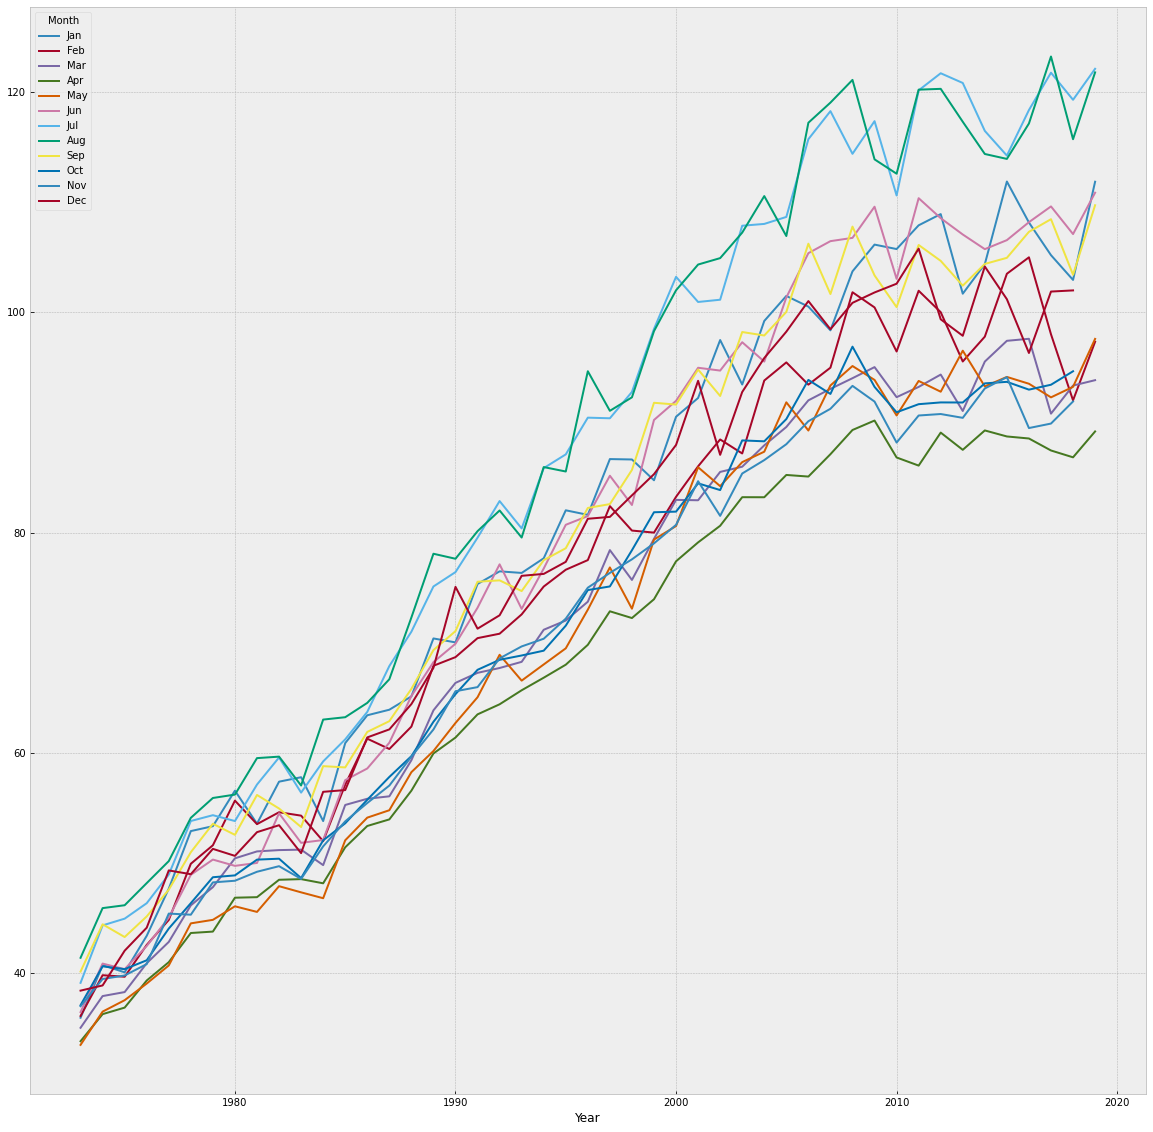

In [21]:
plt.rcParams["figure.figsize"] = (20,20)
fig = yearly_consumption.plot()
plt.show()

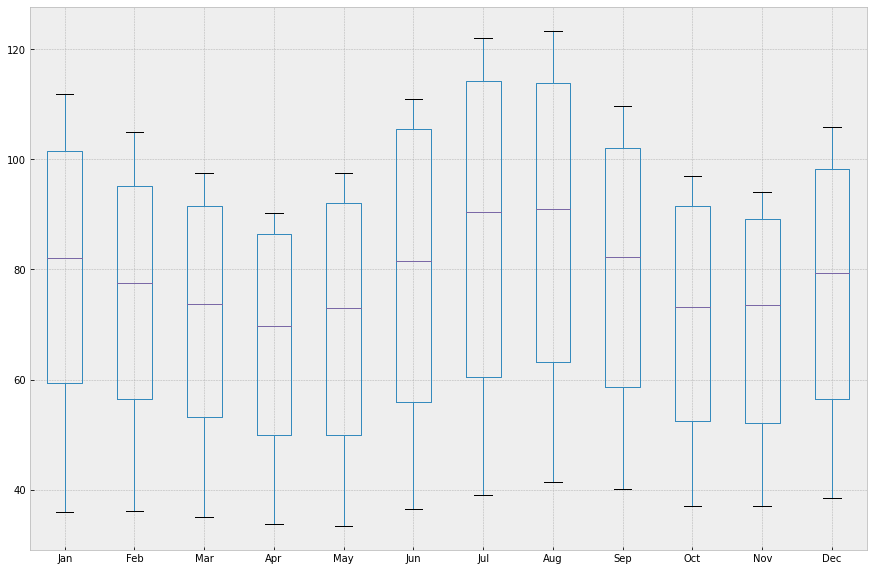

In [22]:
# Another way to check for outliers in the data

plt.figure(figsize = (15, 10))
yearly_consumption.boxplot()
plt.show()

### There is no outlier in the data. 

#### Important Inferences from the yearly_consumption pattern:- 

1. The monthly consumption has been increasing steadily over the years. 


2. There is a seasonal cycle of 12 months. Every year starts with gradual decrease in consumption which continues till May wiht trough at Apr. Then there is gradual increase in consumption with peak at around month of Jul. Thereafter, there is gradual decrease in the consumption which continues till Nov and from Nov onwards there is gradual increase in consumption with peak at around Dec - Jan. 

3. The mean and the variance of the data starts increasing from May onwards and reaches its peak in Jul - Aug. 

### Time Series Decomposition

We will make a multiplicative model with the following equation:- 

Yt = Trendt * Seasonalityt * Irregular_Noiset

These type of simple and plain vanilla models are not used for forecasting. **They are primarily used for understanding the underlying patterns in the data to use in more sophisticated models like Holt-Winters Seasonal method or ARIMA.** 

In [24]:
decomposition = sm.tsa.seasonal_decompose(consumption, model = 'multiplicative', two_sided = True, 
                                          extrapolate_trend = 1, period = 12)


In [25]:
decomposition.seasonal

1973-01-01    1.054483
1973-02-01    0.996364
1973-03-01    0.945856
1973-04-01    0.891021
1973-05-01    0.919000
                ...   
2019-05-01    0.919000
2019-06-01    1.030437
2019-07-01    1.126387
2019-08-01    1.136367
2019-09-01    1.038608
Freq: MS, Name: seasonal, Length: 561, dtype: float64

In [26]:
decomposition.trend

1973-01-01     35.105062
1973-02-01     35.458117
1973-03-01     35.811171
1973-04-01     36.164225
1973-05-01     36.517279
                 ...    
2019-05-01    103.897250
2019-06-01    104.267238
2019-07-01    104.637225
2019-08-01    105.007213
2019-09-01    105.377200
Freq: MS, Name: trend, Length: 561, dtype: float64

In [27]:
decomposition.resid

1973-01-01    0.971773
1973-02-01    1.022763
1973-03-01    1.035141
1973-04-01    1.050228
1973-05-01    0.998549
                ...   
2019-05-01    1.022040
2019-06-01    1.031805
2019-07-01    1.035969
2019-08-01    1.020530
2019-09-01    1.002498
Freq: MS, Name: resid, Length: 561, dtype: float64

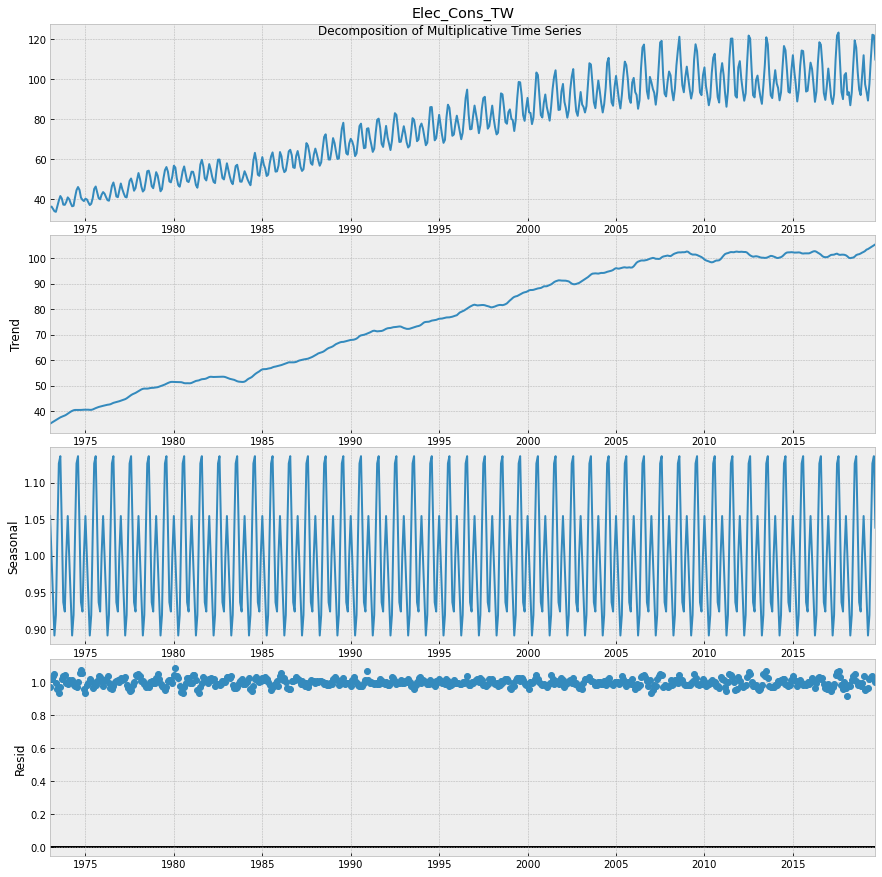

In [28]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(12)
fig.suptitle('Decomposition of Multiplicative Time Series')
plt.show()

In [29]:
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))

In [30]:
decomp_output.columns = ['Observed', 'Trend', 'Seasonal', 'Irregular']

In [31]:
decomp_output.head()

,Observed,Trend,Seasonal,Irregular
1973-01-01,35.9728,35.105062,1.054483,0.971773
1973-02-01,36.1334,35.458117,0.996364,1.022763
1973-03-01,35.0625,35.811171,0.945856,1.035141
1973-04-01,33.8416,36.164225,0.891021,1.050228
1973-05-01,33.5107,36.517279,0.919000,0.998549


In [32]:
decomp_output['Calculated'] = decomp_output['Trend'] * decomp_output['Seasonal'] * decomp_output['Irregular']

In [33]:
decomp_output

,Observed,Trend,Seasonal,Irregular,Calculated
1973-01-01,35.9728,35.105062,1.054483,0.971773,35.9728
1973-02-01,36.1334,35.458117,0.996364,1.022763,36.1334
1973-03-01,35.0625,35.811171,0.945856,1.035141,35.0625
1973-04-01,33.8416,36.164225,0.891021,1.050228,33.8416
1973-05-01,33.5107,36.517279,0.919000,0.998549,33.5107
...,...,...,...,...,...
2019-05-01,97.5860,103.897250,0.919000,1.022040,97.5860
2019-06-01,110.8580,104.267238,1.030437,1.031805,110.8580
2019-07-01,122.1014,104.637225,1.126387,1.035969,122.1014
2019-08-01,121.7765,105.007213,1.136367,1.020530,121.7765


### Dicky Fuller Test

Now let's run the Dicky Fuller Test and find out whether the Time Series data is stationary or not. 

**Stationarity of Time Series Data** - A Time Series data is said to be stationary if the underlying statistical process that changes the data does not changes. That is if the data has constant mean or std deviation throught-out the timeline then the data is said to be stationary. Stationarity of data is important in TSA since it allows for reliable predictions. A data with prominent seasonality with unpredictable peaks/ troughs or unpredictable cyclicity can be termed as non-stationary data. Basically, a data should not have random walk. 

**Stationarity of Time Series Data - Technical Definition** A random variable that is a time series is stationary if its statistical properties are all constant over time.  A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion, i.e., its short-term random time patterns always look the same in a statistical sense.  The latter condition means that its autocorrelations (correlations with its own prior deviations from the mean) remain constant over time, or equivalently, that its power spectrum remains constant over time.  A random variable of this form can be viewed (as usual) as a combination of signal and noise, and the signal (if one is apparent) could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component.

**Stationarity of Data - Simple Definition** Data is called stationary when it has same mean and std dev throughout. **A stationary data will not have any trend and since the data has same mean and std dev throughout, it will have peaks and slumps with same values at equal intervals.** Intuitively, in a stationary data the statistical properties of a process that generates the time series data does not change. It does not mean that the series does not change over time, its just that the way it changes does not changes over time. _**The stationarity of way the data changes allows for the predictions in the Time Series Analysis.**_

An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts.

The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors.  That is:

**Predicted value of Y = a constant and/or a weighted sum of one or more recent values of Y and/or a weighted sum of one or more recent values of the errors.**

**Stationarity**

The Time series data model works on stationary data. The stationarity of data is described by the following three criteria:-

1) It should have a constant mean

2) It should have a constant variance

3) Auto covariance does not depend on the time

*Mean – it is the average value of all the data

*Variance – it is a difference of each point value from the mean

*Auto covariance –it is a relationship between any two values at a certain amount of time.

One way to check for the stationarity is to check the mean and std dev at regular intervals of time and if both the values remain same then the data is said to be stationary. However, this method is cumbersome to implement. 

Therefore we either go for Augmented Dicky Fuller Test or Auto-Correlation Function. 

1. **ADF** - The null hypothesis under this test is that the data is non-stationary and alternate hypothesis is that the data is stationary. Therefore, if the p-value of the test is more than 0.05 then we fail to reject Null Hypothesis and conclude that the data is non-statioanry. Vice-versa for p-value less than 0.05.


2. **ACF** - It is the correlation of data with its delayed copy (or lag) of itself as function of delay. When plotting the ACF for increasing lags (a plot called correlogram) , the values tend to degrade to zero quickly then the data is said to be stationary. For non-stationary data the values will de-grade to zero much more slowly. 

In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
adfuller(consumption)

(-1.7405933729832492,
 0.4103281604468654,
 15,
 545,
 {'1%': -3.442405720052601,
  '5%': -2.866857804790472,
  '10%': -2.5696022094099824},
 2295.409663118043)

In [36]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:','\n')
dftest = adfuller(consumption)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -1.740593
p-value                          0.410328
#lags Used                      15.000000
Number of Observations Used    545.000000
Critical Value (1%)             -3.442406
Critical Value (5%)             -2.866858
Critical Value (10%)            -2.569602
dtype: float64


Since the p-value of the test is more than 0.05, therefore we fail to reject null hypothesis and conclude that the data is not stationary. 

### Rolling Statistics Test :-

The Rolling statistics test can also give the visual representation of the dataset to check for stationarity of the data. For our dataset, the graph of rolling mean and rolling standard deviation is not constant, this shows that our dataset is not stationary.

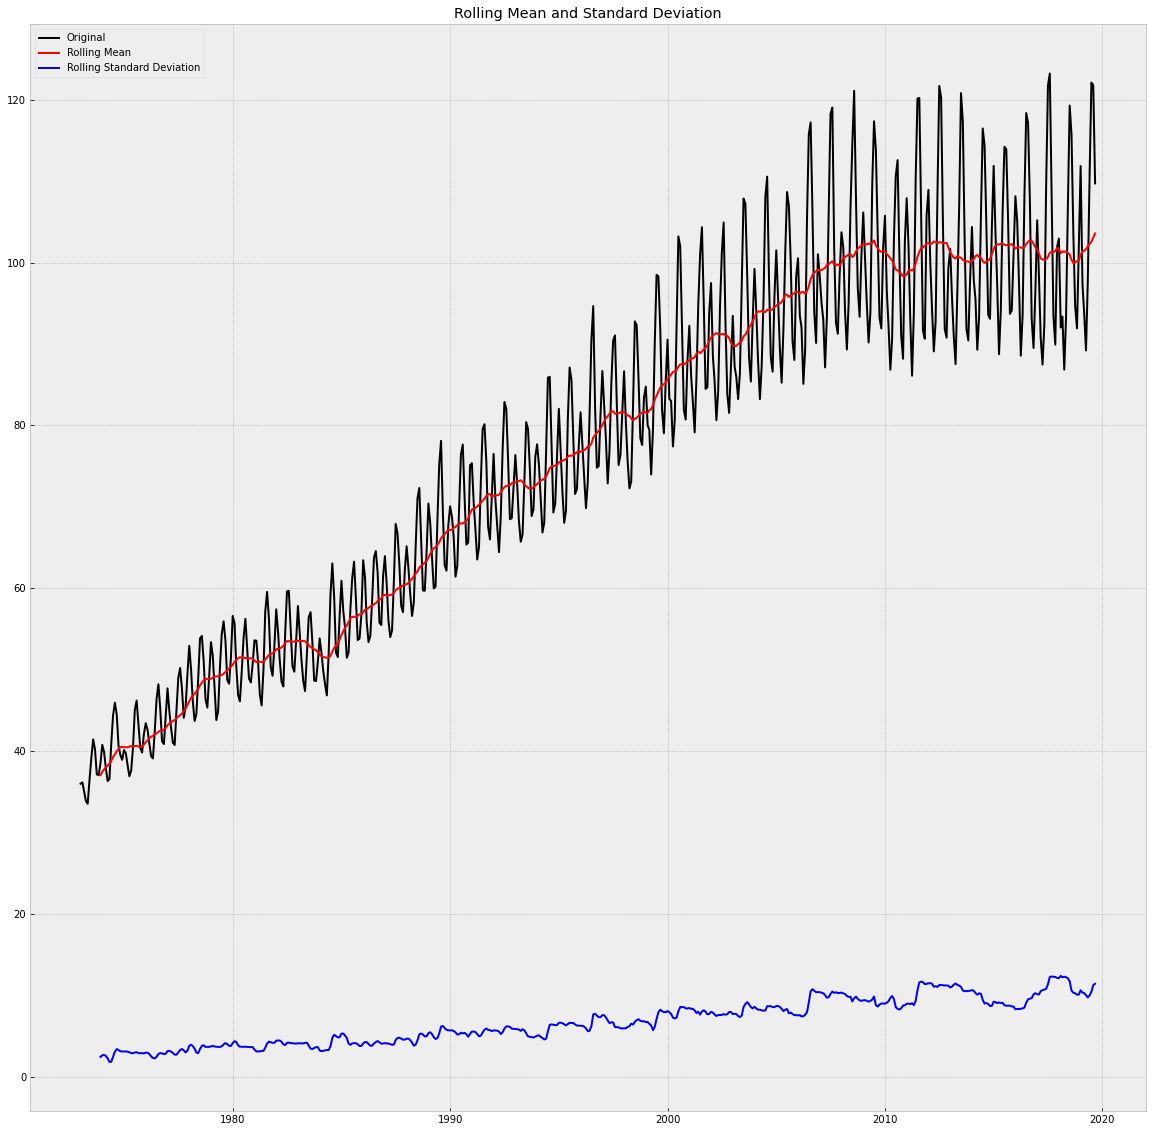

In [37]:
rmean = consumption.rolling(window=12).mean()
rstd = consumption.rolling(window=12).std()

plt.figure(figsize = (20,20))
orig = plt.plot(consumption , color = 'black',label = 'Original')
mean = plt.plot(rmean , color = 'red',label = 'Rolling Mean')
std = plt.plot(rstd,color = 'blue',label = 'Rolling Standard Deviation')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")
plt.show(block = False)

Now we need to make this data stationary. We can start by taking the log of the data for smoothening. 

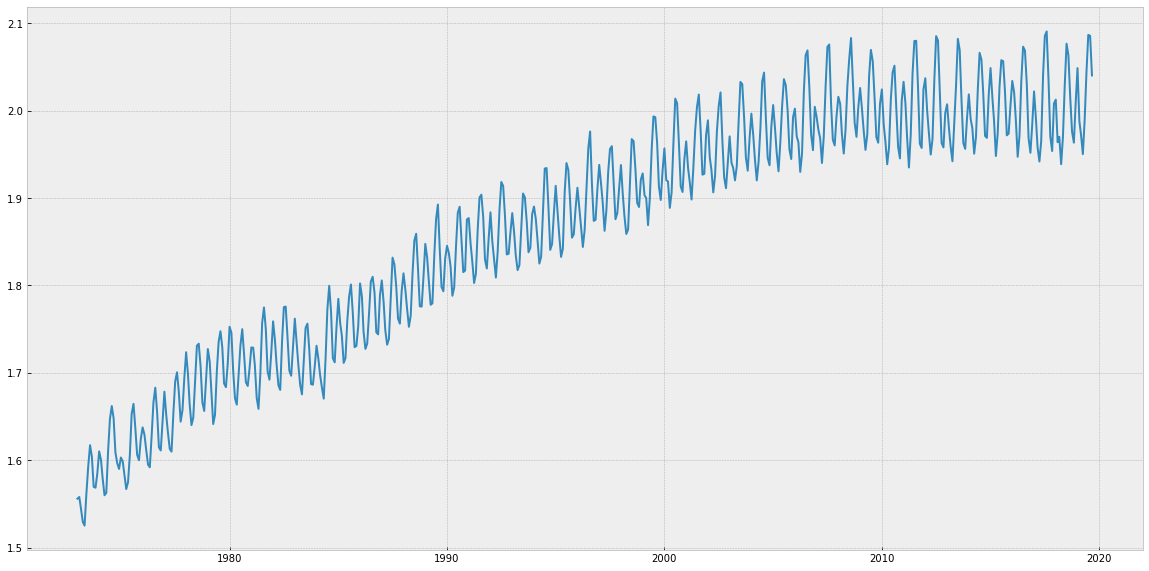

In [38]:
consumption_log = np.log10(consumption)
plt.figure(figsize = (20,10))
plt.plot(consumption_log)
plt.show()

In [39]:
# running ADT on this data

print('Results of ADT:-','\n')
dftest = adfuller(consumption_log)
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of ADT:- 

Test Statistic                  -3.001867
p-value                          0.034720
#lags Used                      15.000000
Number of Observations Used    545.000000
Critical Value (1%)             -3.442406
Critical Value (5%)             -2.866858
Critical Value (10%)            -2.569602
dtype: float64


The p-value for the test is less than 0.05, therefore we conclude that this transformed data is stationary. 

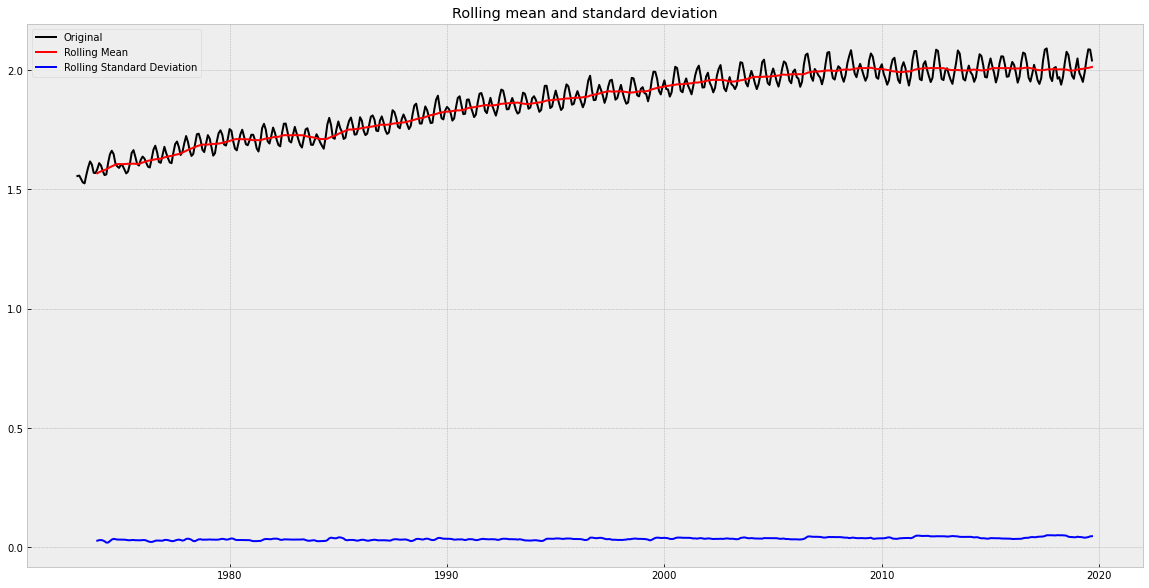

In [40]:
# checking for stationarity of data by using rolling mean and stdev

rmean = consumption_log.rolling(window=12).mean()
rstd = consumption_log.rolling(window=12).std()

plt.figure(figsize = (20,10))
orig = plt.plot(consumption_log , color = 'black',label = 'Original')
mean = plt.plot(rmean , color = 'red',label = 'Rolling Mean')
std = plt.plot(rstd,color = 'blue',label = 'Rolling Standard Deviation')
plt.legend(loc = 'best')
plt.title("Rolling mean and standard deviation")
plt.show(block = False)

Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then we can safely conclude that the series is very likely not to be stationary.


In our case rolling mean and std dev are nealy constant across the time-spectrum which means that the data is stationary. 

In [41]:
consumption_log_d1 = consumption_log.diff(1)

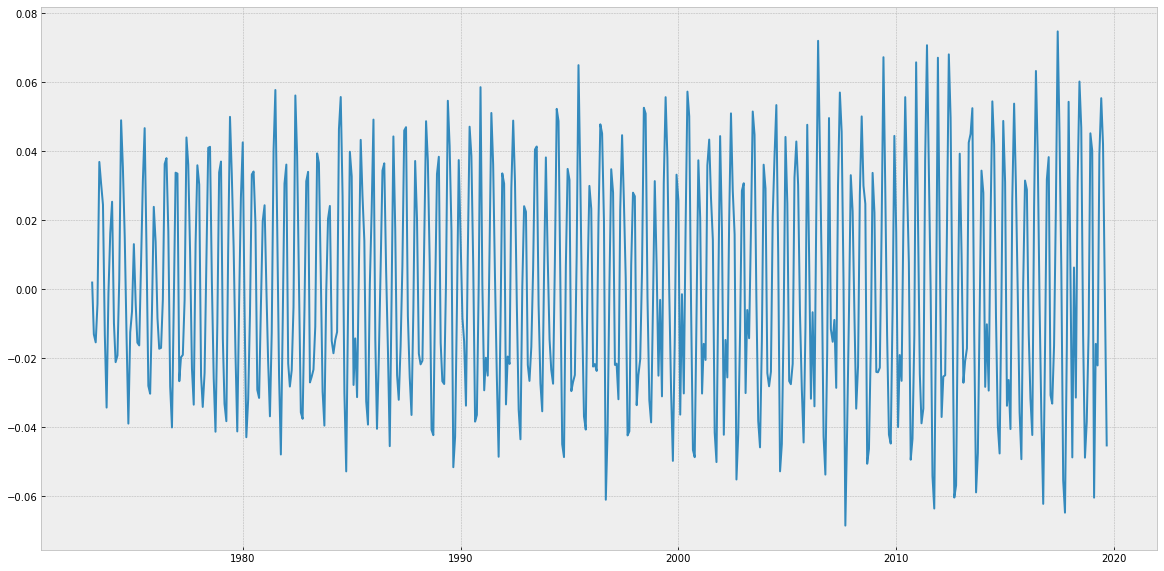

In [42]:
plt.figure(figsize = (20,10))
plt.plot(consumption_log_d1)
plt.show()

In [43]:
print('Results of ADT:-','\n')
dftest = adfuller(consumption_log_d1.dropna())
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of ADT:- 

Test Statistic                -6.884810e+00
p-value                        1.403418e-09
#lags Used                     1.400000e+01
Number of Observations Used    5.450000e+02
Critical Value (1%)           -3.442406e+00
Critical Value (5%)           -2.866858e+00
Critical Value (10%)          -2.569602e+00
dtype: float64


#### p-value is extremely low as compared to that of consumption_log. Therefore we will chose consumption_log_d1 for our modelling purposes. 

### Auto Correlation and Partial Auto Correlation

ACF helps in detecting patterns and checking for randomness in the data. Randomness in data is defined as absence of any patterns. It is especially important when we want to use any moving - average based model such as ARIMA for forecasting as it helps to determine its parameters. ACF/ PACF is used to determine the ordre of AR, MA or ARMA models. 

Auto Regressive Models - AR models assume that current value is dependent upon previous values and because of this assumption, we can build the regression model for prediction. To figure out the order of AR model, we need to look at the PACF. 

Moving Average Models - MA models assume that the current value is dependent upon the error terms including the current error terms. And because the error terms are random, there is no linear relation between the current value and the error terms. We need to look at ACF for the order of MA models. 

Both ACF and PACF assume that the data is stationary. 

### The ACF plot can provide answers to the following questions:

1. Is the observed time series white noise/random?
    
2. Is an observation related to an lag_1 or lag_2 and so on?
    
3. Can the observed time series be modeled with an MA model? If yes, what is the order?

Autocorrelation depicts the association of a sequence with itself after a certain number of time units. When plotted, the X-axis represents the lag number, and the Y-axis represents the correlation of the sequence with a sequence at that lag. The Y-axis scales from -1 to 1.

ACF helps determine if there are any seasonal patterns or tendencies. In an ACF plot, each bar represents the size and direction of the correlation between the series and it's lag. Bars that cross the blue zone represent significant correlation and that particular lag number can be used as q in the model. 


An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself. A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.

### The PACF plot can provide answers to the following question:

1. Can the observed time series be modeled with an AR model? If yes, what is the order?

The partial autocorrelation function removes the intermediary correlation between the two data points and represents the true correlation between two data points. For example if Yt is correlated with lag_1 and lag_2 then lag_1 and lag_2 are also correlated with each other. At this point, the correlation of lag_1 and lag_2 seeps into the correlation of Yt with lag_2 and inflates the value. PACF removes this inflation and represents the correlation between Yt and lag_2 only. Therefore, PACF indicates only the association between two data points that the intermediary lags between those observations do not explain. In other words, the partial correlation for each lag is the unique correlation between two observations after the intermediate correlations have been removed. 

As previously stated, the autocorrelation function aids in determining the qualities of a time series. The partial autocorrelation function (PACF), on the other hand, is more beneficial during the definition phase for an autoregressive model. Partial autocorrelation plots can be used to specify regression models with time series data as well as Auto-Regressive Integrated Moving Average (ARIMA) models.

**Choosing a model**

1. If there is geometric decay in ACF and significance at lag p/ cut-off at lag p then it is AR(p) model. 
2. If there is geometric decay in PACF and significance at lag q/ cut-off at lag q then it is MA(q) model. 
3. If there is geometric decay in both ACF and PACF then it is ARMA model with values of p and q being determined by the signifcance at a particular lag in ACF and PACF plot. 

ARIMA models should be used on stationary data only. We can make the data stationary either by averaging, log or any other transformation or by differencing. The number of differencing used to make the data stationary determines the value of d (Integrated) part of the ARIMA model. 

More often than not we are required to use combination of two of these techniques to make our data stationary. 

**PACF --> p and ACF --> q**

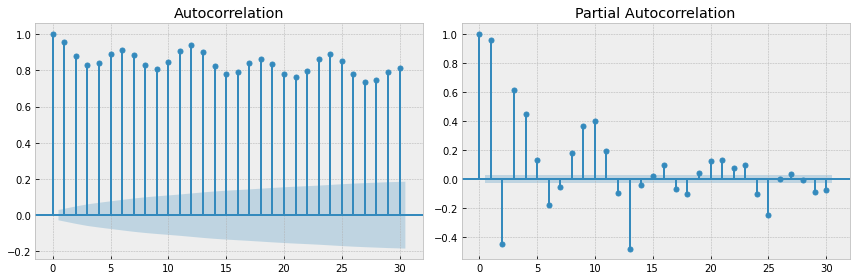

In [44]:
fig, axes = plt.subplots(1, 2, sharey = False, sharex = False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(consumption, lags = 30, ax = axes[0], alpha = 0.5)
smt.graphics.plot_pacf(consumption, lags = 30, ax = axes[1], alpha = 0.5)
plt.tight_layout()

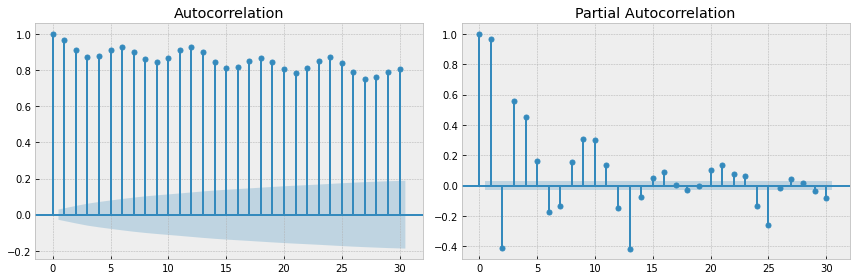

In [45]:
fig, axes = plt.subplots(1, 2, sharey = False, sharex = False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(consumption_log, lags = 30, ax = axes[0], alpha = 0.5)
smt.graphics.plot_pacf(consumption_log, lags = 30, ax = axes[1], alpha = 0.5)
plt.tight_layout()

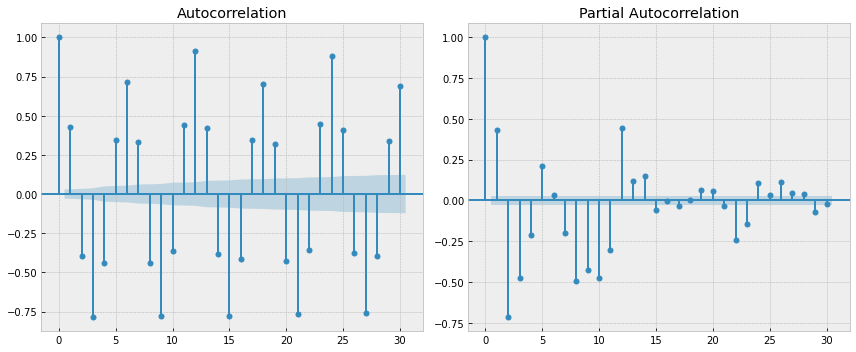

In [46]:
fig, axes = plt.subplots(1, 2, sharey = False, sharex = False)
fig.set_figwidth(12)
fig.set_figheight(5)
smt.graphics.plot_acf(consumption_log_d1.dropna(), lags = 30, ax = axes[0], alpha = 0.5)
smt.graphics.plot_pacf(consumption_log_d1.dropna(), lags = 30, ax = axes[1], alpha = 0.5)
plt.tight_layout()

We can make the following observations:

   1. There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
   2. High degree of autocorrelation between adjacent (lag = 1) and (lag = 2) in PACF plot.Strong correlation at lag = 3, 4 and moderate correlation at lag = 5. 
   3. There is no geometric decay in ACF plot
   4. ACF function plot shows the seasonality in the data. 
   5. Since there are enough spikes outside the blue zone, we can conclude that the residuals are not random. This implies that there is information available in the residuals which are to be extracted using AR and MA models. 
   6. Also there is seasonal component available at lag = 12, represented by spikes at lag = 12 which makes sense since we are analyzing monthly data that tends to have seasonality of 12 months.

As the value of PACF gradually decreases to zero, therefore the consumption_log data is stationary. From the above PACF plot if you observe the values at regular intervals, at the 12th lag it is correlated to 0th lag and for 24 lag correlation further decreases and further, it is getting weaker and weaker. 

The plot of PACF is a little difficult to follow. It performs the same function as regular autocorrelation in that it displays the correlation of a sequence with itself after a certain number of time units have passed. However, there is a catch. All intermediary effects are erased, leaving only the direct effect visible. PACF brings out the relation between today's consumption and that of some time ago (may be a year ago). In this case we are not concerned what has happened in between. The consumption of the previous 12 months has an effect on the consumption of the previous 11 months, and the cycle continues until the most current period. In partial autocorrelation estimates, these indirect effects are ignored.

In the context of Time Series Analysis, before modelling the time series one should analyze the autocorrelation and partial autocorrelation in order to get proper insight from the series. These steps are basically carried out to be sure and to have evidence that the given data is a function of time. By observing and interpreting the above plots one can decide which time series modelling technique to use further like autoregressive, moving average, etc.

#### From the ACF and PACF plot of consumption_log data, we can start with the values of p = 1 and q = 1 since at these lag_1 both the graphs have maximum correlation as compared to that of other lags. The value of d = 1

In [47]:
model = sm.tsa.statespace.SARIMAX(consumption_log_d1, order = (1,1,1), seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
results = model.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28067D+00    |proj g|=  2.07463D+01

At iterate    5    f= -2.51817D+00    |proj g|=  1.84619D+00

At iterate   10    f= -2.67364D+00    |proj g|=  7.08731D+01

At iterate   15    f= -2.86125D+00    |proj g|=  4.26327D+00

At iterate   20    f= -2.93292D+00    |proj g|=  7.98755D+00

At iterate   25    f= -2.94329D+00    |proj g|=  2.52330D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     52      1     0     0   

#### Now iterate over the values of p, d and q

In [48]:
# generate all possible combination of p, d and q
p = q = range(0,2)
d = range(2,3)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 2, 0), (0, 2, 1), (1, 2, 0), (1, 2, 1)]

In [49]:
# generate all possible combinations of seasonal P, D and Q
P = Q = range(0,2)
D = range(2,3)
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(P,D,Q))]
seasonal_pdq

[(0, 2, 0, 12), (0, 2, 1, 12), (1, 2, 0, 12), (1, 2, 1, 12)]

In [70]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(consumption_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99032D+00    |proj g|=  1.63491D+00
  ys=-6.627E-11  -gs= 2.700E-10 BFGS update SKIPPED
  ys=-1.685E-09  -gs= 5.828E-08 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4     57      2     2     0   2.435D-02  -1.991D+00
  F =  -1.9909127040008257     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22312D+00    |proj g|=  2.05961D+01


 This problem is unconstrained.



At iterate    5    f= -2.35615D+00    |proj g|=  1.04211D+00

At iterate   10    f= -2.37091D+00    |proj g|=  1.34621D+01

At iterate   15    f= -2.38219D+00    |proj g|=  5.89114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     26      1     0     0   5.891D-04  -2.382D+00
  F =  -2.3821938622383656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.15259D+00    |proj g|=  1.08260D-02


 This problem is unconstrained.


  ys=-1.668E-13  -gs= 2.260E-13 BFGS update SKIPPED
  ys=-8.560E-17  -gs= 2.472E-16 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3     50      3     2     0   2.552D-02  -2.153D+00
  F =  -2.1525870648414558     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32156D+00    |proj g|=  1.18813D+01

At iterate    5    f= -2.34672D+00    |proj g|=  3.38684D-01

At iterate   10    f= -2.35667D+00    |proj g|=  1.09255D+01

At iterate   15    f= -2.45207D+00    |proj g|=  4.39138D+00

At iterate   20    f= -2.45366D+00    |proj g|=  4.51412D-01

At iterate   25    f= -2.45407D+00    |proj g|=  2.88109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     43      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28018D+00    |proj g|=  5.99538D+00

At iterate    5    f= -2.30943D+00    |proj g|=  1.29754D+01

At iterate   10    f= -2.36719D+00    |proj g|=  3.15059D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     28      1     0     0   5.154D-03  -2.368D+00
  F =  -2.3683827023670010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.38077D+00    |proj g|=  2.85352D+01

At iterate    5    f= -2.64655D+00    |proj g|=  3.02242D+00

At iterate   10    f= -2.72296D+00    |proj g|=  2.58312D+01

At iterate   15    f= -2.74538D+00    |proj g|=  1.60708D+00

At iterate   20    f= -2.74962D+00    |proj g|=  8.21372D-01

At iterate   25    f= -2.74966D+00    |proj g|=  6.29851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     45      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.37813D+00    |proj g|=  1.78314D+01

At iterate    5    f= -2.44796D+00    |proj g|=  3.70908D-01

At iterate   10    f= -2.45485D+00    |proj g|=  7.43321D+00

At iterate   15    f= -2.51723D+00    |proj g|=  1.11762D+01

At iterate   20    f= -2.52991D+00    |proj g|=  1.29692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     35      1     0     0   1.297D-02  -2.530D+00
  F =  -2.5299073058773689     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -2.63456D+00    |proj g|=  3.72961D-01

At iterate   10    f= -2.70335D+00    |proj g|=  4.24390D+01

At iterate   15    f= -2.78173D+00    |proj g|=  1.30874D+00

At iterate   20    f= -2.78563D+00    |proj g|=  7.32600D+00

At iterate   25    f= -2.81874D+00    |proj g|=  6.93119D-01

At iterate   30    f= -2.81880D+00    |proj g|=  2.74006D-02

At iterate   35    f= -2.81916D+00    |proj g|=  5.38601D-03

At iterate   40    f= -2.81917D+00    |proj g|=  1.56905D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     64      1     0     0   1.581D-02  -2.819D+00
  F =  -2.81916531566

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09557D+00    |proj g|=  1.52294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   1.523D-02  -2.096D+00
  F =  -2.0955671405311298     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.24730D+00    |proj g|=  2.35867D+01


 This problem is unconstrained.



At iterate    5    f= -2.46066D+00    |proj g|=  9.88883D-01

At iterate   10    f= -2.48612D+00    |proj g|=  1.75802D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     26      1     0     0   3.332D-03  -2.486D+00
  F =  -2.4861207350121224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.21347D+00    |proj g|=  1.23313D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -2.25222D+00    |proj g|=  1.28846D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     75      3     0     0   1.288D-02  -2.252D+00
  F =  -2.2522210973356844     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31525D+00    |proj g|=  2.03422D+01


 This problem is unconstrained.



At iterate    5    f= -2.45273D+00    |proj g|=  1.31857D+00

At iterate   10    f= -2.49628D+00    |proj g|=  3.33960D+01

At iterate   15    f= -2.55991D+00    |proj g|=  1.74821D-01

At iterate   20    f= -2.55998D+00    |proj g|=  2.66166D-01

At iterate   25    f= -2.56036D+00    |proj g|=  5.64386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   4.215D-03  -2.560D+00
  F =  -2.5603626643132449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f= -2.33211D+00    |proj g|=  9.05689D+00

At iterate   10    f= -2.36807D+00    |proj g|=  1.35833D+00

At iterate   15    f= -2.37195D+00    |proj g|=  6.92210D-01

At iterate   20    f= -2.37629D+00    |proj g|=  5.61691D-03
  ys=-1.226E-09  -gs= 1.489E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     82      2     1     0   2.077D-02  -2.376D+00
  F =  -2.3762908039389190     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.38644D+00    |proj g|=  2.89237D+01


 This problem is unconstrained.



At iterate    5    f= -2.66435D+00    |proj g|=  6.10260D+00

At iterate   10    f= -2.74368D+00    |proj g|=  6.12518D+00

At iterate   15    f= -2.75054D+00    |proj g|=  3.21728D-01

At iterate   20    f= -2.75815D+00    |proj g|=  5.88718D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     44      1     0     0   3.913D-02  -2.758D+00
  F =  -2.7581508023012549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.38309D+00    |proj g|=  1.84562D+01

At iterate    5    f= -2.45906D+00    |proj g|=  3.97962D-01

At iterate   10    f= -2.46912D+00    |proj g|=  8.95130D+00

At iterate   15    f= -2.51564D+00    |proj g|=  5.92940D+00

At iterate   20    f= -2.52442D+00    |proj g|=  1.15662D+00

At iterate   25    f= -2.53329D+00    |proj g|=  1.86816D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     39      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -2.65128D+00    |proj g|=  4.24680D-01

At iterate   10    f= -2.70117D+00    |proj g|=  2.34957D+01

At iterate   15    f= -2.75423D+00    |proj g|=  3.58779D-01

At iterate   20    f= -2.75613D+00    |proj g|=  6.55378D+00

At iterate   25    f= -2.81713D+00    |proj g|=  1.43156D+01

At iterate   30    f= -2.82654D+00    |proj g|=  9.59059D-02

At iterate   35    f= -2.82671D+00    |proj g|=  2.48624D-01

At iterate   40    f= -2.82729D+00    |proj g|=  9.07426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     55      1     0     0   1.293D-02  -2.827D+00
  F =  -2.82729545489

Best SARIMAX(1, 2, 1)x(1, 2, 1, 12) model - AIC: -3162.225500395418 when the input data is consumption_log

Best SARIMAX(1, 2, 1)x(1, 2, 1, 12) model with - AIC: -2845.0750792858325 when the input data is consumption_log_d1 

Best SARIMAX(1, 2, 1)x(1, 2, 1, 12) model with - AIC: 2351.8803931591096 when the input data is consumption

Since best AIC is with consumption data in the model above, therefore we will use consumption as our data for the final_model

In [81]:
final_model = sm.tsa.SARIMAX(consumption,
                            order = (1,2,1), 
                            seasonal_order = (1,2,1,12),
                            enforce_invertibility = False,
                            enforce_stationarity = False)
results = final_model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45002D+00    |proj g|=  1.36372D-01


 This problem is unconstrained.



At iterate    5    f=  2.22631D+00    |proj g|=  2.24326D-01

At iterate   10    f=  2.09035D+00    |proj g|=  2.39666D-01

At iterate   15    f=  2.08724D+00    |proj g|=  1.37644D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   3.914D-06   2.087D+00
  F =   2.0872374270580298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                       Elec_Cons_TW   No. Observations:                  561
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 12)   Log

In [74]:
# predictions when the input data is consumption_log
pred_dynamic_consumption_log = results.get_prediction(start = pd.to_datetime('1973-01-01'), full_results = True)
np.power(10, pred_dynamic_consumption_log.predicted_mean)

1973-01-01      1.000000
1973-02-01    574.543342
1973-03-01     40.491077
1973-04-01     33.748146
1973-05-01     32.694503
                 ...    
2019-05-01     95.171084
2019-06-01    113.459824
2019-07-01    123.878951
2019-08-01    120.460218
2019-09-01    107.677426
Freq: MS, Name: predicted_mean, Length: 561, dtype: float64

In [147]:
# predictions when the input data is consumption only
pred_dynamic_consumption = results.get_prediction(start = pd.to_datetime('1973-01-01'), full_results = True)
pred_dynamic_consumption.predicted_mean 

1973-01-01      0.000000
1973-02-01     63.726781
1973-03-01     37.472026
1973-04-01     33.939402
1973-05-01     32.632815
                 ...    
2019-05-01     95.021325
2019-06-01    112.896850
2019-07-01    123.650088
2019-08-01    120.652597
2019-09-01    107.894582
Freq: MS, Name: predicted_mean, Length: 561, dtype: float64

In [148]:
np.column_stack([consumption, pred_dynamic_consumption.predicted_mean])

array([[ 35.9728    ,   0.        ],
       [ 36.1334    ,  63.72678072],
       [ 35.0625    ,  37.47202599],
       ...,
       [122.1014    , 123.65008822],
       [121.7765    , 120.65259676],
       [109.719     , 107.8945818 ]])

The predictions with the consumption data as the input to the SARIMAX model is pretty close to our actual consumptoin values.

In [149]:
pred_dynamic_consumption = pd.Series(pred_dynamic_consumption.predicted_mean)
MAPE = np.mean(np.abs(consumption - pred_dynamic_consumption)/consumption)
print('The Mean Absolute percentage error of our forecast is {}%'.format(round(MAPE, 4)*100))

The Mean Absolute percentage error of our forecast is 2.78%


In [150]:
# Compute the mean square error
mse = ((consumption - pred_dynamic_consumption) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse),4)))

The Mean Squared Error of our forecasts is 10.7773
The Root Mean Squared Error of our forecasts is 3.2829


#### Forecast for next 36 Months (next 3 years)

In [130]:
# .forecast will forecast the value based on number of steps provided. It will start from the end of input series
results.forecast(steps = 36).head()

2019-10-01     97.915809
2019-11-01     94.821858
2019-12-01    106.033191
2020-01-01    112.441596
2020-02-01     99.006534
Freq: MS, Name: predicted_mean, dtype: float64

In [132]:
# Get Confidence Intervals for the forecast upto 3 years
n_steps = 36

# .get_forecast will both forecast and give the confidence intervals
pred_uc_99 = results.get_forecast(steps = 36, alpha = 0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = results.get_forecast(steps = 36, alpha = 0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [102]:
pred_ci_99.head()

,lower Elec_Cons_TW,upper Elec_Cons_TW
2019-10-01,93.596464,102.235154
2019-11-01,89.116029,100.527687
2019-12-01,99.157703,112.908679
2020-01-01,104.564480,120.318711
2020-02-01,90.230996,107.782071


In [104]:
pred_ci_95.head()

,lower Elec_Cons_TW,upper Elec_Cons_TW
2019-10-01,93.596464,102.235154
2019-11-01,89.116029,100.527687
2019-12-01,99.157703,112.908679
2020-01-01,104.564480,120.318711
2020-02-01,90.230996,107.782071


In [154]:
idx = pd.date_range(start = '2019-10-01', periods = 36, freq = 'MS')
fc_95 = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [155]:
fc_95.head()

,forecast,lower_ci_95,upper_ci_95
2019-10-01,97.915809,93.596464,102.235154
2019-11-01,94.821858,89.116029,100.527687
2019-12-01,106.033191,99.157703,112.908679
2020-01-01,112.441596,104.564480,120.318711
2020-02-01,99.006534,90.230996,107.782071


In [156]:
fc_99.head()

,lower_ci_99,upper_ci_99
2019-10-01,93.596464,102.235154
2019-11-01,89.116029,100.527687
2019-12-01,99.157703,112.908679
2020-01-01,104.564480,120.318711
2020-02-01,90.230996,107.782071


#### Trivia :- 

.combine_first is generally used to fill the Null values in one dataframe with values from other dataframe in the corresponding position. However, if the name of columns are different in both the dataframes then it just unions the two dataframes in one big dataframe.

In [157]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2019-10-01,97.915809,93.596464,102.235154,93.596464,102.235154
2019-11-01,94.821858,89.116029,100.527687,89.116029,100.527687
2019-12-01,106.033191,99.157703,112.908679,99.157703,112.908679
2020-01-01,112.441596,104.564480,120.318711,104.564480,120.318711
2020-02-01,99.006534,90.230996,107.782071,90.230996,107.782071


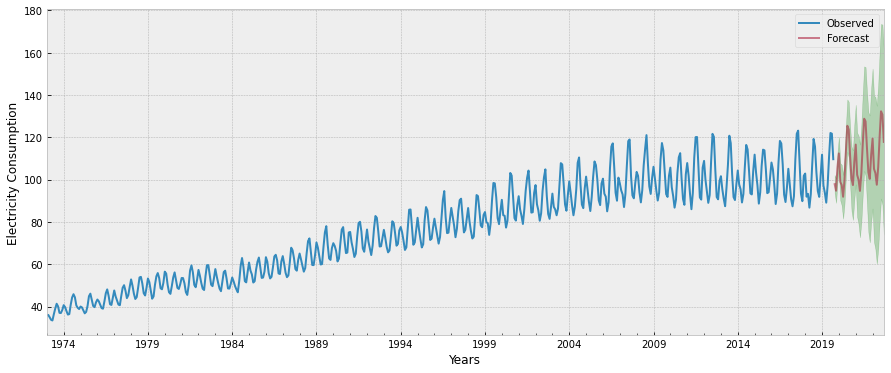

In [192]:
axis = consumption.plot(label = 'Observed',figsize=(15, 6))
fc_all['forecast'].plot(ax = axis, label = 'Forecast', alpha = 0.5)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color = 'g', alpha = 0.25)
# axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color = 'k', alpha = .25)
axis.set_xlabel('Years')
axis.set_ylabel('Electricity Consumption')
plt.legend(loc = 'best')
plt.show()

### Diagnostics

1. Errors follows normality

2. Errors should not have auto correlation (ACF, no spikes beyond the limits)

3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict properly)

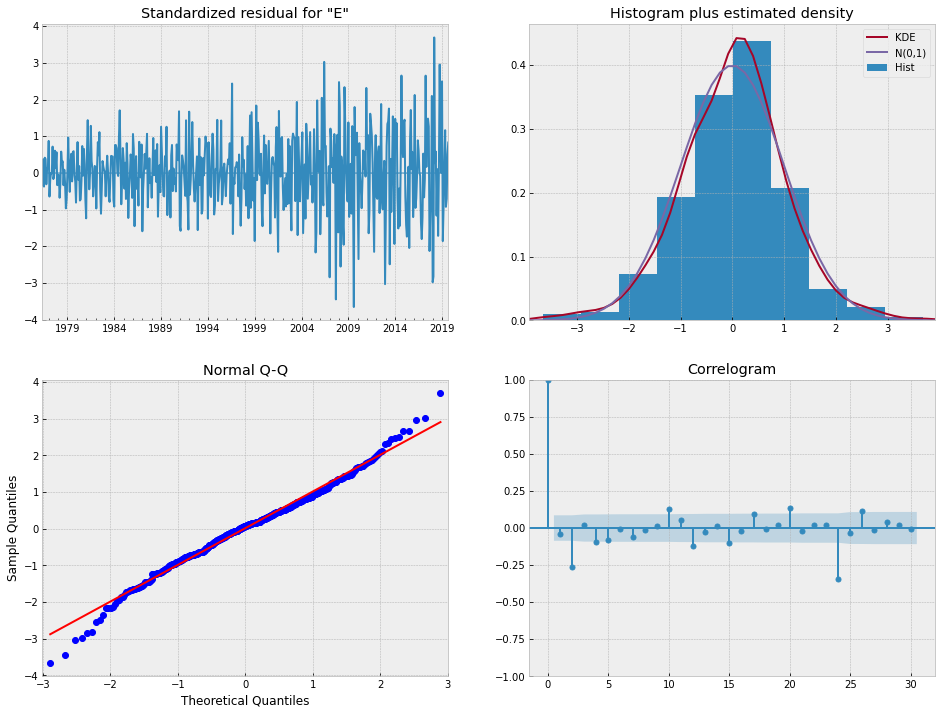

In [160]:
results.plot_diagnostics(lags = 30, figsize = (16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.
In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:-

- The KDE plot of the residuals on the top right is almost similar with the normal distribution.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself except for two occasions where the lag is 2 and 24. Model may have predicted properly for these two time periods. 

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.

### Exponential Time Smoothing Forecasting Method

Exponential smoothings methods are appropriate for non-stationary data (ie data with a trend and seasonal data).
Exponential Time Smoothing Forecasting Method are similar to ARIMA family of methods in that a prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations. In other words, more recent the observation the higher the associated weight and the more older the observation, the lower the associated weight. 

Exponential Time Smoothing methods can be considered as alternative to popular ARIMA family of methods. The methods are also referred as explicity modelling of Error, Trend and Seasonality. 

There are 3 types of ETS methods: -

1. **Single Exponential Smoothing** - SES is a time series forecasting method for univariate data without trend or seasonality. It requires single parameter called ɑ (alpha) - also called smoothing factor. This parameter controls the rate at which the influence of the observations at prior time steps decays expnentially. Alpha is often set to values between 0 and 1. Large values means that the model is paying attention to the most recent past observations whereas smaller values means more of the history is taken into account when making decisions. Therefore, a value close to 1 indicates fast learning (ie only the most recent values influence the forecast) whereas a value close to 0 indicates slow learning (past observations have a large influence of forecasts). 


2. **Double Exponential Smoothing** - DES is an extension of SES which adds support for Trend in the univariate time series analysis. In addition to the alpha (ɑ) parameter for controlling the smoothing parameter for the level, an additional smoothing factor called β is added to control the decay of influence of change in trend. The method supports trends that change as additive or multiplicative depending upon whether the trend is linear or exponential. DES with an additive trend is classically referred to as Holt's Linear Trend Model. 

    1. Additive Trend - DES with linear trend
    2. Multiplicative Trend - DES with exponential trend
    
For longer range (multi-step forecast), the trend may continue on unrealistically and it can be useful to dampen the trend over time. Dampening means reducing the size of trend over future time steps down to straight line (no trend). The forecast generated by Holt's Linear method display a constant trend (increasing or decreasing) indecently to the future. Even more extreme are the forecasts generated by the exponential trend method. Therefore a third parameter Phi (ɸ) is introduced that controls the rate of dampenening the trend to a flat line some time in the future. Hyper-parameters for DES:- 

    1. Alpha - smoothing factor for the level
    2. Beta - Smoothing factor for the trend
    3. Trend Type - Additive or Multiplicative
    4. Dampen Type - Additive or Multiplicative
    5. Phi - Damping coefficient
    
    
3. **Triple Exponential Smoothing** - TES is an extension of DES which adds support for Seasonality. This method is sometimes called Holt-Winter's Exponential Smoothing. In addition to the alpha and beta smoothing factors a new parameter is added called gamma (Ɣ) that controls the influence on the seasonal component. As with trend, the seasonality may be modelled as either additive or multiplicative process for a linear or exponential change in the seasonality. 

    1. Additive Seasonality - TES with linear seasonality.  
    2. Multiplicative Seasonality - TES with exponential seaonality. 
    
TES is the most advanced variation of ES adn through configuration it can also develop DES and SES models. Therefore, being an adaptive method, Holt-Winter's exponential smoothing allows the level, trend and seasonality patterns to change over time. Additionally, to ensure that the seasonality is modelled correctly, the number of time steps in a seasonal period must be specified. For example, if the series was monthly data and the seasonal period repeated each year then the Period is 12. Hyper-parameters for DES:- 

    1. Alpha - smoothing factor for the level
    2. Beta - Smoothing factor for the trend
    3. Gamma - Smoothing factor for the seasonality
    4. Trend Type - Additive or Multiplicative
    5. Dampen Type - Additive or Multiplicative
    6. Phi - Damping coefficient
    7. Seasonality Type - Additive or Multiplicative
    8. Period - Time steps in seasonal period
    
4. **How to Configure Exponential Smoothing** - Basically how to select optimum values of hyper-parameters - One way can be minimizing the SSE by estimating the unknown parameters and initial values for any exponential smoothing. The parameters that specify the type of change in the trend or seasonality, such as weather they are additive or multiplicative and whether they should be dampened must be specified explicitly. 

In [52]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as SES

In [53]:
# creating the first model with alpha = 0.2

model_SES = SES(consumption_log)
model_SES_fit_1 = model_SES.fit(smoothing_level = 0.2, optimized = False)
pred_con_log_1 = model_SES_fit_1.forecast(12).rename('alpha = 0.2')
10 ** pred_con_log_1

2019-10-01    107.949656
2019-11-01    107.949656
2019-12-01    107.949656
2020-01-01    107.949656
2020-02-01    107.949656
2020-03-01    107.949656
2020-04-01    107.949656
2020-05-01    107.949656
2020-06-01    107.949656
2020-07-01    107.949656
2020-08-01    107.949656
2020-09-01    107.949656
Freq: MS, Name: alpha = 0.2, dtype: float64

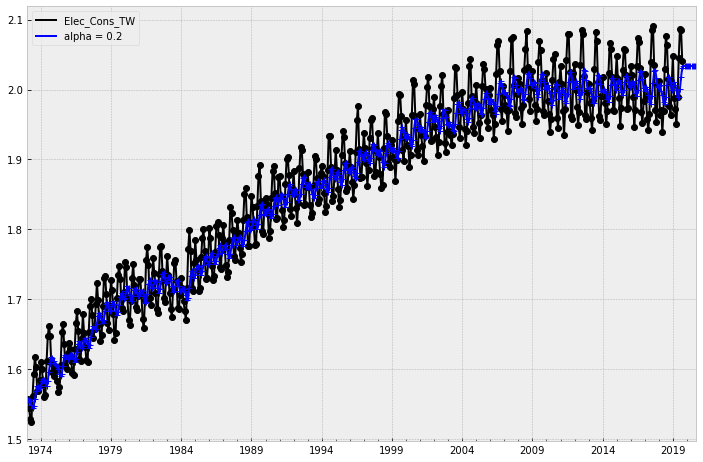

In [54]:
# Visualize the plot
ax = consumption_log.plot(marker='o', color='black', figsize=(12,8), legend=True)

#Plot for alpha = 0.2
pred_con_log_1.plot(marker='+', ax=ax, color='blue', legend=True)
model_SES_fit_1.fittedvalues.plot(marker='+', ax=ax, color='blue')


plt.show()


In [55]:
# creating the second model with alpha = 0.8

model_SES = SES(consumption_log)
model_SES_fit_2 = model_SES.fit(smoothing_level = 0.8, optimized = False)
pred_con_log_2 = model_SES_fit_2.forecast(12).rename('alpha = 0.8')
10 ** pred_con_log_2

2019-10-01    111.930762
2019-11-01    111.930762
2019-12-01    111.930762
2020-01-01    111.930762
2020-02-01    111.930762
2020-03-01    111.930762
2020-04-01    111.930762
2020-05-01    111.930762
2020-06-01    111.930762
2020-07-01    111.930762
2020-08-01    111.930762
2020-09-01    111.930762
Freq: MS, Name: alpha = 0.8, dtype: float64

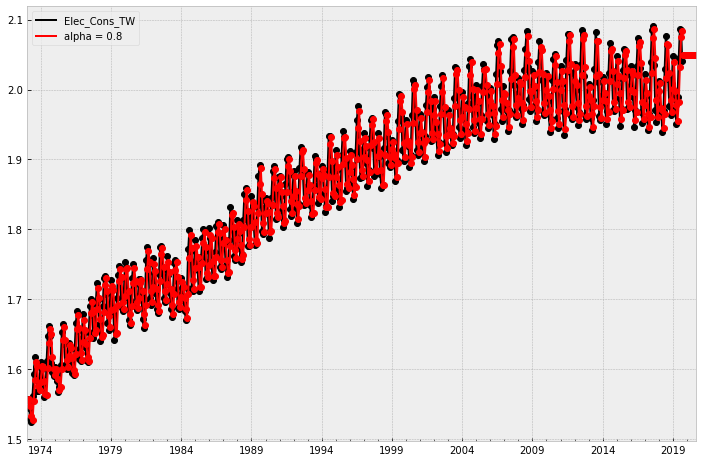

In [56]:
# Visualize the plot
ax = consumption_log.plot(marker='o', color='black', figsize=(12,8), legend=True)

#Plot for alpha = 0.8
pred_con_log_2.plot(marker='o', ax=ax, color='red', legend=True)
model_SES_fit_2.fittedvalues.plot(marker='o', ax=ax, color='red')

plt.show()

In [57]:
# now letting the model select the best value of alpha. Here we will not mention the value
# of smoothing level explicitly like we have done for the two models above. 

model_SES = SES(consumption_log)
model_SES_fit_3 = model_SES.fit()
pred_con_log_3 = model_SES_fit_3.forecast(12).rename('alpha=%s'%model_SES_fit_3.model.params['smoothing_level'])
10 ** pred_con_log_3

2019-10-01    109.719
2019-11-01    109.719
2019-12-01    109.719
2020-01-01    109.719
2020-02-01    109.719
2020-03-01    109.719
2020-04-01    109.719
2020-05-01    109.719
2020-06-01    109.719
2020-07-01    109.719
2020-08-01    109.719
2020-09-01    109.719
Freq: MS, Name: alpha=0.9999999850988388, dtype: float64

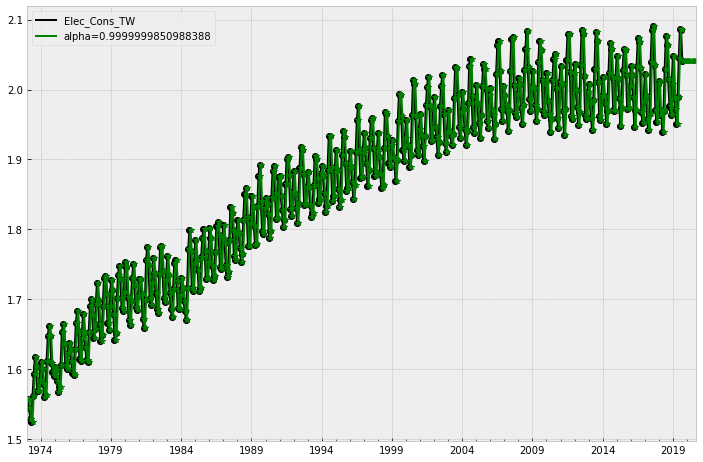

In [58]:
# Visualize the plot
ax = consumption_log.plot(marker='o', color='black', figsize=(12,8), legend=True)

#Plot for alpha=Optimized by statsmodel
pred_con_log_3.plot(marker='*', ax=ax, color='green', legend=True)
model_SES_fit_3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

SES with any value of alpha does not produce good results as it does not cater for the trend and seaonality in the data. 

In [59]:
# Using Triple Exponential Smoothing Method (Holt-Winters method) which caters for trend and seasonality

from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES

In [60]:
model_ES = ES(consumption_log, trend = 'mul', damped_trend = True, seasonal = 'mul' )
model_ES_fit = model_ES.fit()
pred_cons_log_4 = model_ES_fit.forecast(12)
10 ** pred_cons_log_4

2019-10-01     96.873121
2019-11-01     94.657925
2019-12-01    105.256687
2020-01-01    111.867771
2020-02-01    102.249421
2020-03-01     98.967920
2020-04-01     92.946328
2020-05-01     99.694641
2020-06-01    114.660045
2020-07-01    126.393687
2020-08-01    125.009341
2020-09-01    111.612422
Freq: MS, dtype: float64

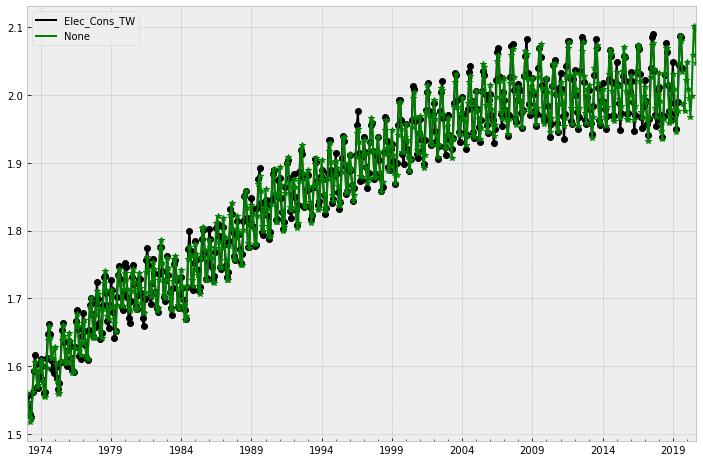

In [61]:
# Visualize the plot
ax = consumption_log.plot(marker='o', color='black', figsize=(12,8), legend=True)

#Plot for alpha=Optimized by statsmodel
pred_cons_log_4.plot(marker='*', ax=ax, color='green', legend=True)
model_ES_fit.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

The results for Triple Exponential Smoothing are almost the same as that for Simple Exponential Smoothing for alpha = 0.8.

# FINISH